# HED6659, run75, BK50/Al0.2/LiF150, PP250, 5.6 J in 9.5 ns

## Modules

In [2]:
# Necessary modules
import numpy as np 
import matplotlib.pyplot as plt
import os
import sys
from HED_outputs import *
from HPLF_visar import *
import matplotlib
matplotlib.warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2\
%matplotlib widget

ModuleNotFoundError: No module named 'HED_outputs'

## Path to data and parameters

Path to reference and shot data directories

In [2]:
path_base = 'C:/Users/jean1509/Documents/Projects/VISAR_proc/notebooks/HED_data'
path_im1_ref = 'KEPLER1_r75_ref_downsample.tiff'
path_im1_shot = 'KEPLER1_r75_shot_0_downsample.tiff'
path_im2_ref = 'KEPLER2_r75_ref_downsample.tiff'
path_im2_shot = 'KEPLER2_r75_shot_0_downsample.tiff'


Streak and VISAR parameters

In [3]:
# Downsampling coef
downsampling_coef = 2

# VISAR1 parameters
S1_param = {
    "name":'KEPLER1',
    "window":'20ns',
    "DG_chA":None,
    "gain":None,
    "t0_px":int(2096/downsampling_coef),
    "delay_to_drive":10,
    "pos0_px":int(2100/downsampling_coef),
    "fov":1050*downsampling_coef,
    "counts_bkg":0,
    "tX":10,
    "sizeX":15,
    "poly_coefs":np.array([5.80e-3*downsampling_coef, 0, 0, 0])
    }

# VISAR2 parameters
S2_param = {
    "name":'KEPLER2',
    "window":'20ns',
    "DG_chA": None,
    "gain": None,
    "t0_px":int(2070/downsampling_coef),
    "delay_to_drive":10,
    "pos0_px":int(2100/downsampling_coef),
    "fov":1050*downsampling_coef,
    "counts_bkg":0,
    "tX":10,
    "sizeX":15,
    "poly_coefs":np.array([5.53e-3*downsampling_coef, 0, 0, 0])
    }

Loading data from ref and shot folders

In [4]:
# Reference
ref_outputs = EuXFEL_outputs(path_base, path_im1_ref, path_im2_ref)
# Shot
shot_outputs = EuXFEL_outputs(path_base, path_im1_shot, path_im2_shot)

## Plot VISAR images and rotate them if necessary

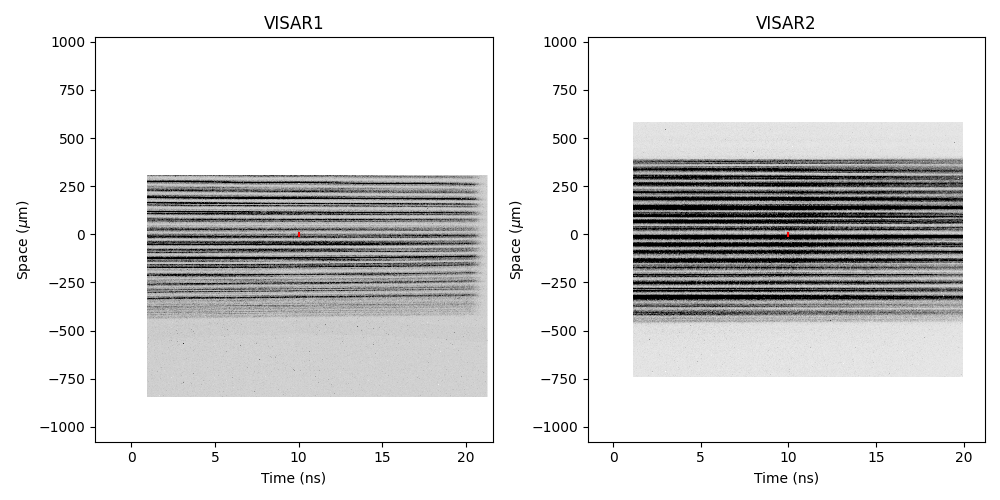

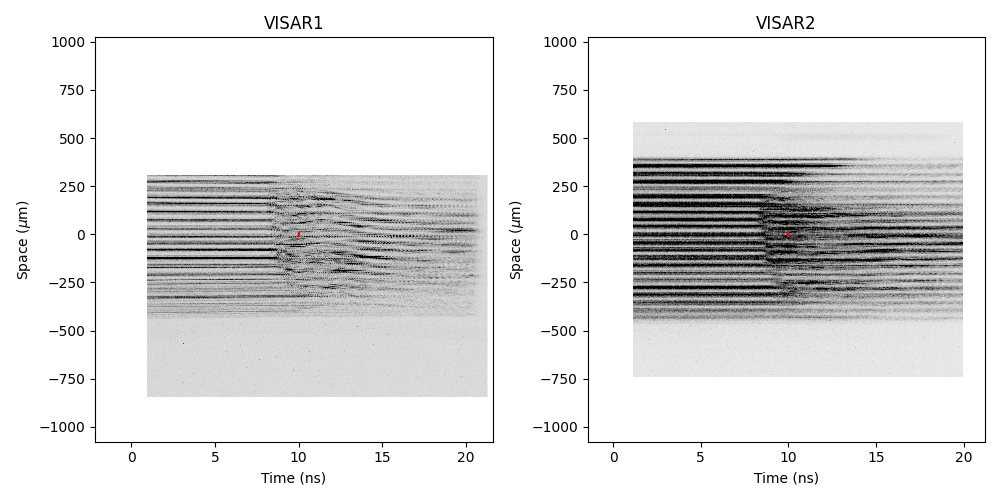

In [5]:
%matplotlib widget
# # # Rotate images
# ref_outputs.VISAR1.rotate_im(0)
# shot_outputs.VISAR1.rotate_im(0)
# ref_outputs.VISAR2.rotate_im(0)
# shot_outputs.VISAR2.rotate_im(0)
# Plot VISAR images
ref_outputs.plot_VISAR_images(S1_param, S2_param, calibrated=True, cmap='binary')
shot_outputs.plot_VISAR_images(S1_param, S2_param, calibrated=True, cmap='binary')

## VISAR analysis

Define ROIs for analysis

In [6]:
VISAR1_space_lim = (-420, 300)
VISAR1_time_lim = (1.5, 20.5)
VISAR1_ROI = [VISAR1_space_lim, VISAR1_time_lim]
VISAR2_space_lim = (-440, 380)
VISAR2_time_lim = (1.5, 19.8)
VISAR2_ROI = [VISAR2_space_lim, VISAR2_time_lim]

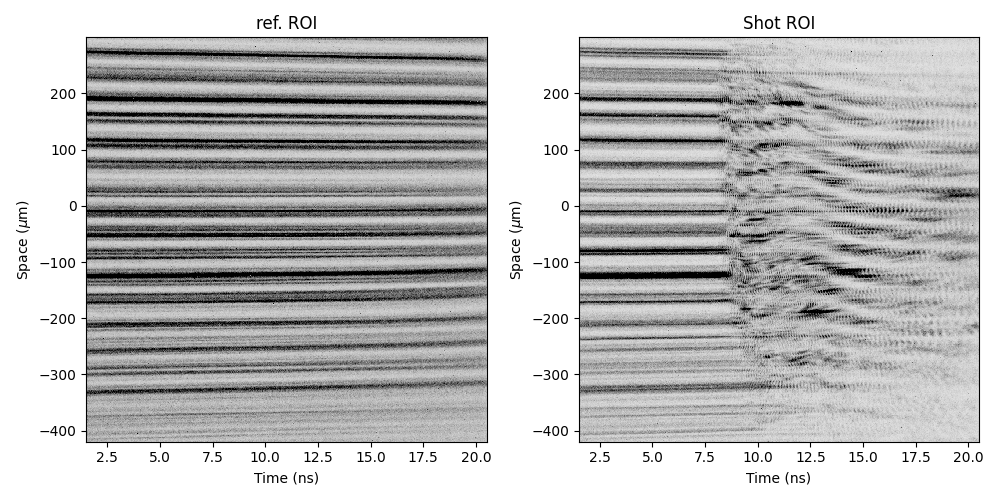

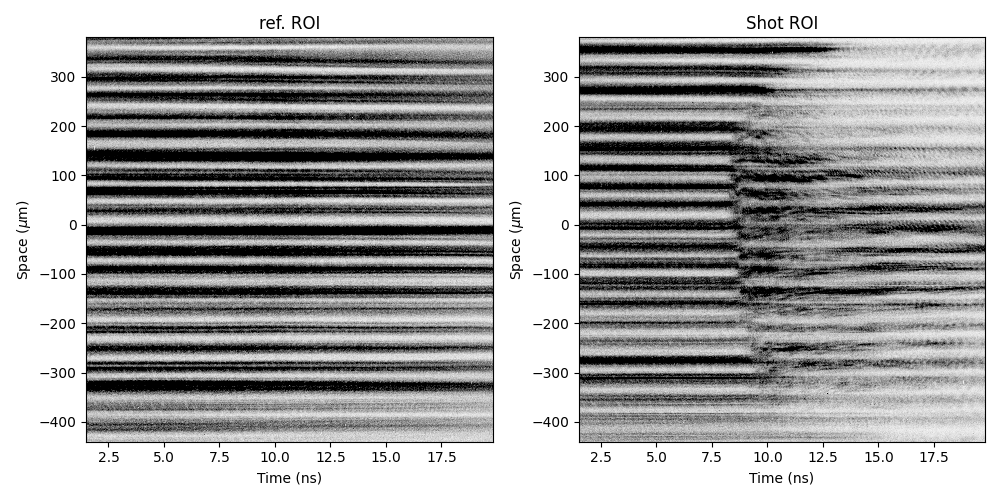

In [7]:
# VISAR1
VISAR1_process = HPLF_visar(ref_outputs.VISAR1, shot_outputs.VISAR1, wavelength=532e-9, dict_etalon={'sign':1, 'VPF':1.607}, ROI=VISAR1_ROI)
VISAR1_process.apply_ROI()
# # VISAR2
VISAR2_process = HPLF_visar(ref_outputs.VISAR2, shot_outputs.VISAR2, wavelength=532e-9, dict_etalon={'sign':-1,'VPF':6.229}, ROI=VISAR2_ROI)
VISAR2_process.apply_ROI()

Optional deghost procedure

In [8]:
# # defining ROI for deghost
# VISAR1degh_space_lim = (-200, 370)
# VISAR1degh_time_lim = (2.1, 6.5)
# VISAR1degh_ROI = [VISAR1degh_space_lim, VISAR1degh_time_lim]
# VISAR2degh_space_lim = (-320, -40)
# VISAR2degh_time_lim = (2.1, 6.5)
# VISAR2degh_ROI = [VISAR2degh_space_lim, VISAR2degh_time_lim]

# # 2D FFT over selected region
# VISAR1_process.deghost(deghROI=VISAR1degh_ROI, dqt=0.002, apply=False)
# VISAR2_process.deghost(deghROI=VISAR2degh_ROI, dqt=0.002, apply=False)


Apply FT and choose filter band

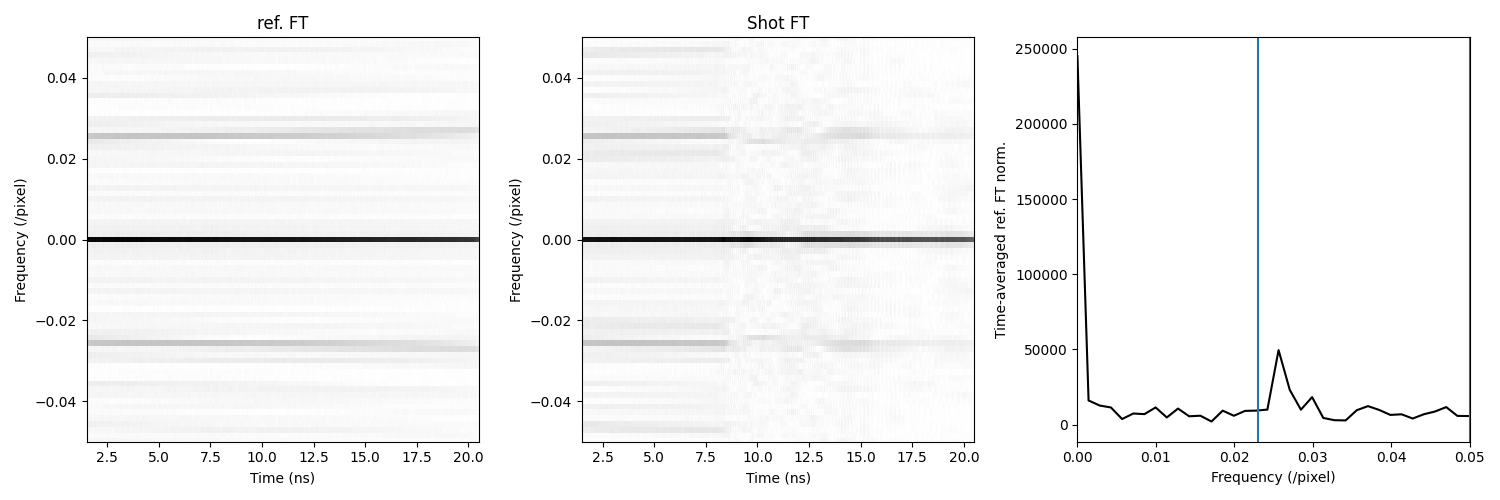

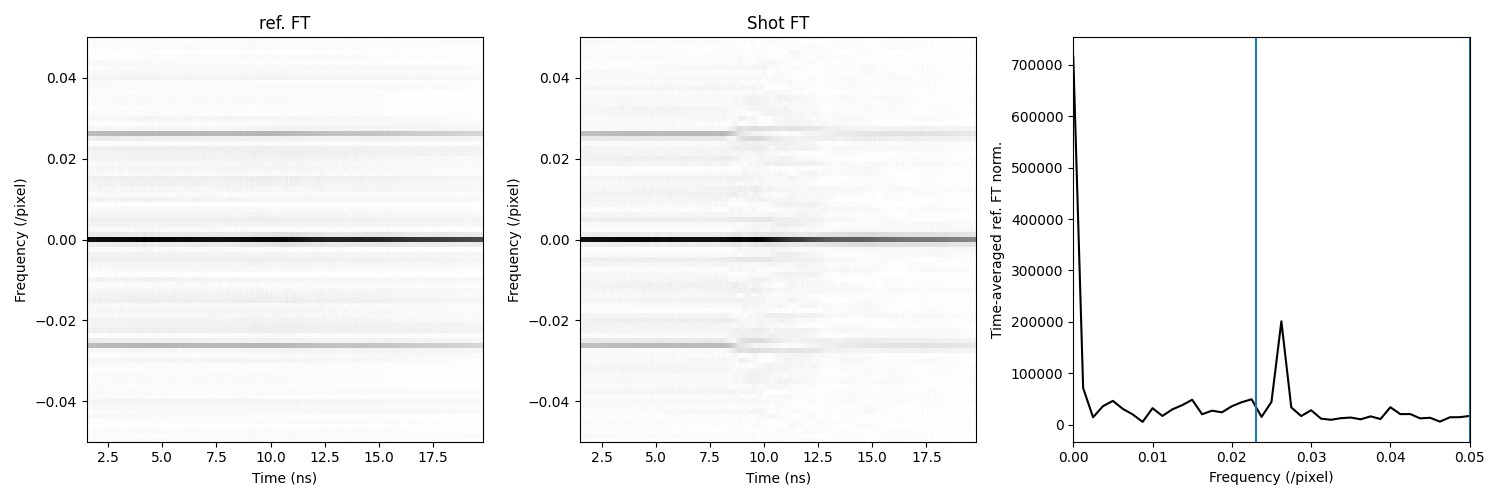

In [21]:
# VISAR1
VISAR1_filter_bounds = [0.023, 0.05]
VISAR1_process.FFT_process(VISAR1_filter_bounds)
# VISAR2
VISAR2_filter_bounds = [0.023, 0.05]
VISAR2_process.FFT_process(VISAR2_filter_bounds)

Apply bandpass filter, calculate BACKWARD FT and phase maps

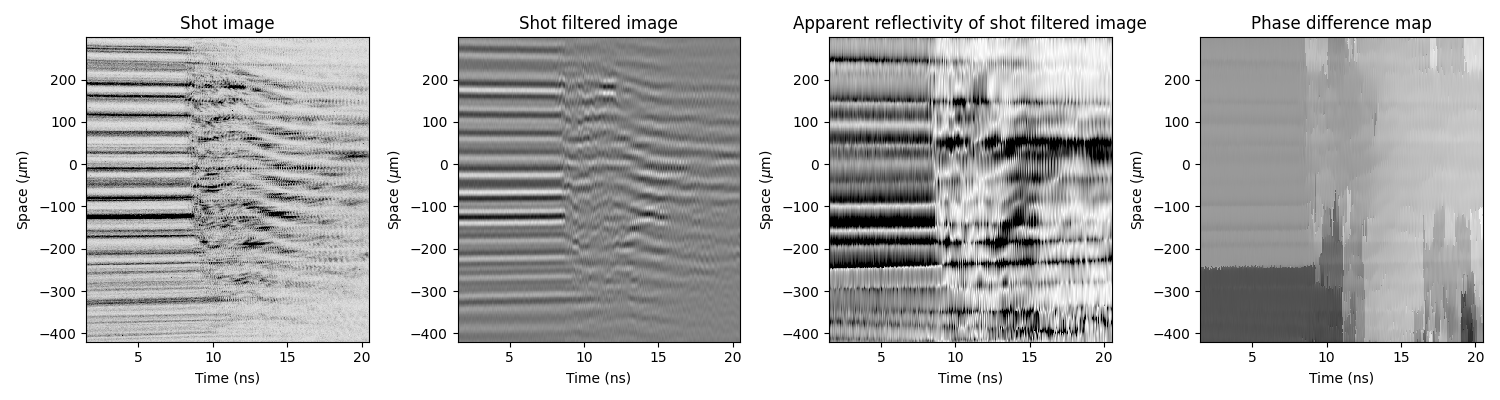

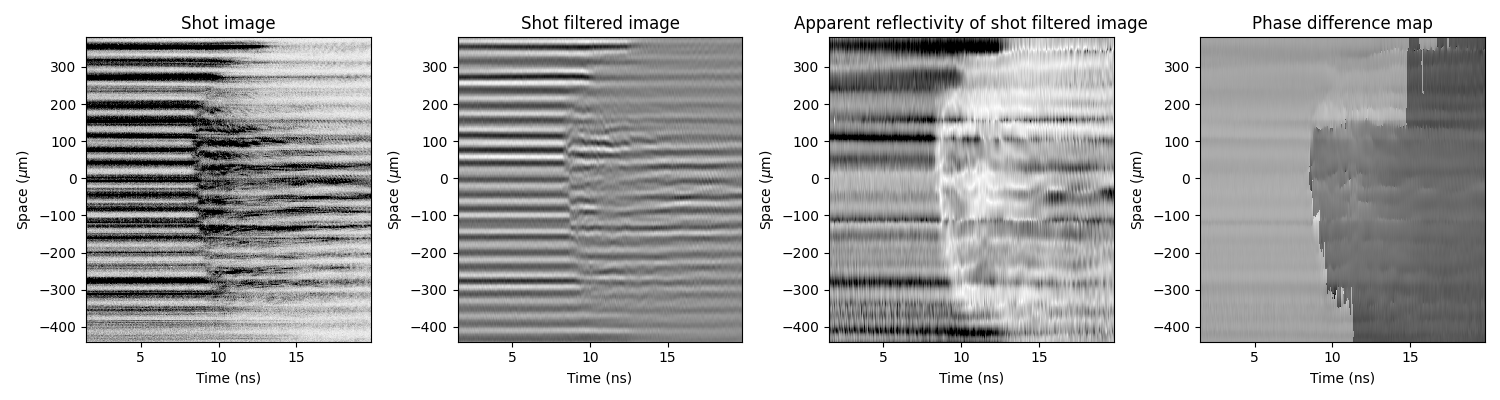

In [22]:
VISAR1_process.Filter()
VISAR2_process.Filter()

Calculate spatially averaged apparent velocity on a second ROI based on phase difference map, apply offset, jumps and corrective index.

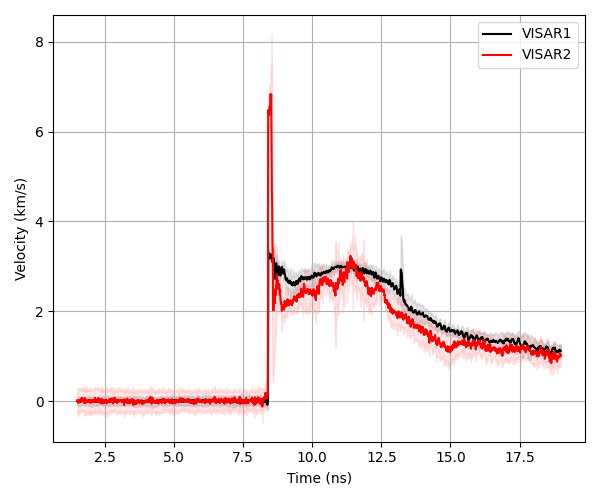

In [25]:
# First iteration without jump and with offset at 0 to guess offset
[V1_t, V1_v, V1_verr] = VISAR1_process.Velocity(offset=0, tjump_list=[], njump_list=[], corr_index_list=[], vROI=[(0, 100), (1.5, 19)])
[V2_t, V2_v, V2_verr] = VISAR2_process.Velocity(offset=0, tjump_list=[], njump_list=[], corr_index_list=[], vROI=[(0, 100), (1.5, 19)])
V1_offset = -np.average(V1_v[np.where(V1_t<4)])
V2_offset = -np.average(V2_v[np.where(V2_t<4)])
# Second call where parameters can be adjusted
[V1_t, V1_v, V1_verr] = VISAR1_process.Velocity(offset=V1_offset, tjump_list=[8.4], njump_list=[2], corr_index_list=[1], vROI=[(0, 100), (1.5, 19)])
[V2_t, V2_v, V2_verr] = VISAR2_process.Velocity(offset=V2_offset, tjump_list=[8.4], njump_list=[1], corr_index_list=[1], vROI=[(0, 100), (1.5, 19)])

# Plot
fig = plt.figure(figsize=(6,5))
ax1=fig.add_subplot(111)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Velocity (km/s)')
ax1.plot(V1_t, V1_v, 'k-', label='VISAR1')
ax1.fill_between(V1_t, V1_v-V1_verr, V1_v+V1_verr, color='k', alpha=0.1)
ax1.plot(V2_t, V2_v, 'r-', label='VISAR2')
ax1.fill_between(V2_t, V2_v-V2_verr, V2_v+V2_verr, color='r', alpha=0.1)

# ax1.set_ylim(-1, 6)
ax1.legend(loc='best')
ax1.grid()
fig.tight_layout()
plt.show()

## Impedance matching / analysis of velocity signal

*** Results of impedance matching ***

Conditions measured in LiF:
	Up measured in LiF = 3.000 km/s
	P in LiF = 72.9 GPa

Conditions measured in BKapton:
	Up in BKapton = 4.205 km/s
	P in BKapton = 46.4 GPa


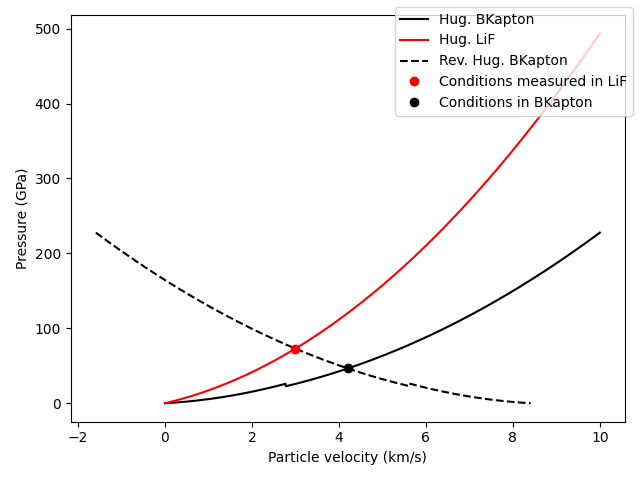

In [20]:
# Load Hugoniot
from Velocity_analysis import *

vecUp = np.linspace(0, 10, 1001)

LiF = LiF()
BKapton = BKapton() # Based on Katagiri et al. PRB (2022)

IM_BK_LiF = impedance_matching(BKapton, LiF, 'Up_2', vecUp, 3.0, plot=True) 